# Test
Here take a quick look at COVID-19 data and implement fits.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy import optimize

Get and adapt data

In [2]:
url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv"
df = pd.read_csv(url)

In [3]:
df.head()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
0,2020-02-24 18:00:00,ITA,13,Abruzzo,42.351222,13.398438,0,0,0,0,0,0,0,0,0,5
1,2020-02-24 18:00:00,ITA,17,Basilicata,40.639471,15.805148,0,0,0,0,0,0,0,0,0,0
2,2020-02-24 18:00:00,ITA,4,P.A. Bolzano,46.499335,11.356624,0,0,0,0,0,0,0,0,0,1
3,2020-02-24 18:00:00,ITA,18,Calabria,38.905976,16.594402,0,0,0,0,0,0,0,0,0,1
4,2020-02-24 18:00:00,ITA,15,Campania,40.839566,14.250850,0,0,0,0,0,0,0,0,0,10


In [4]:
df = df[ df['denominazione_regione']=='Lombardia' ]

FMT = '%Y-%m-%d %H:%M:%S'
date = df['data']
df['day'] = date.map(lambda x : (datetime.datetime.strptime(x, FMT) - datetime.datetime.strptime("2020-01-01 00:00:00", FMT)).days  )

df['day'] = df['day'] - df['day'].min()

Quick check

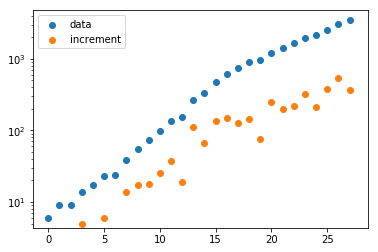

In [5]:
log=True

plt.figure()
plt.title('')

plt.scatter(df['day'], df['deceduti'], label='data');
plt.scatter(df['day'].values[1:], np.diff(df['deceduti']), label='increment');

plt.legend(loc='best')
if log:
    plt.yscale('log')

In [6]:
x = df['day']
x = x - x.min()

y = df['deceduti']
ylog = np.log(y)

Fit with `np.polyfit(...)`. As per [documentation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html) the fitted function is:
```
p(x) = p[0] * x**deg + ... + p[deg]
```

In [7]:
df[['data', 'day']]

,data,day
9,2020-02-24 18:00:00,0
30,2020-02-25 18:00:00,1
51,2020-02-26 18:00:00,2
72,2020-02-27 18:00:00,3
93,2020-02-28 18:00:00,4
114,2020-02-29 17:00:00,5
135,2020-03-01 17:00:00,6
156,2020-03-02 18:00:00,7
177,2020-03-03 18:00:00,8
198,2020-03-04 17:00:00,9


slope for "early" data: 0.2909829556036855
slope for "late" data: 0.15500238337676145


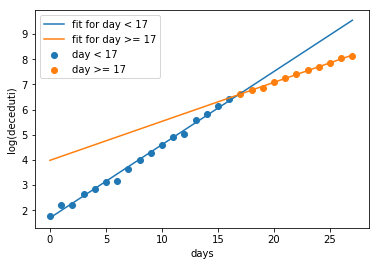

In [8]:
thr = 17

plt.figure()

plt.scatter(x[:thr], ylog[:thr], label=f'day < {thr}');
plt.scatter(x[thr:], ylog[thr:], label=f'day >= {thr}');

f1 = np.polyfit(x[:thr], ylog[:thr], 1)
f2 = np.polyfit(x[thr:], ylog[thr:], 1)

plt.plot(x, f1[1] + f1[0]*x, label=f'fit for day < {thr}')
plt.plot(x, f2[1] + f2[0]*x, label=f'fit for day >= {thr}')
print('slope for "early" data:', f1[0])
print('slope for "late" data:', f2[0])

_ = plt.legend(loc='best')
_ = plt.ylabel('log(deceduti)')
_ = plt.xlabel('days')

Go back to the actual value, transform the fit result accordingly.

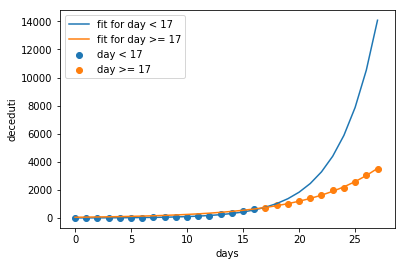

In [25]:
plt.figure()

plt.scatter(x[:thr], y[:thr], label=f'day < {thr}');
plt.scatter(x[thr:], y[thr:], label=f'day >= {thr}');

plt.plot(x, np.exp(f1[1] + f1[0]*x), label=f'fit for day < {thr}')
plt.plot(x, np.exp(f2[1] + f2[0]*x), label=f'fit for day >= {thr}')

_ = plt.legend(loc='best')
_ = plt.ylabel('deceduti')
_ = plt.xlabel('days')

Check: the daily increments are the derivative of the cumulative curve. If the cumulative curve is exponential, its derivative is exponential too :\

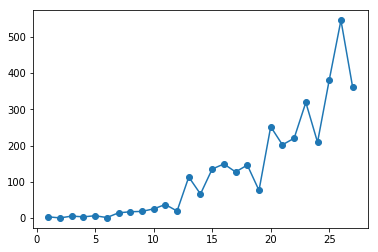

In [26]:
plt.plot(x[1:], np.diff(y), marker='o');

Run an exponential fit

In [28]:
p0_0 = np.max(y)
p0_1 = 0
p0_2 = 1e-3
p0_3 = 5

p0 = [p0_0, p0_1, p0_2, p0_3] # shouldn't the first value be median(y)?
fitfunc = lambda x, a, b, c, d : a * np.exp((x+b) * c)  + d

popt, pcov = optimize.curve_fit(fitfunc, x, y, p0=p0, bounds=([0.,-np.inf, 0., -np.inf],[np.inf,np.inf, np.inf, np.inf]), sigma=None) 

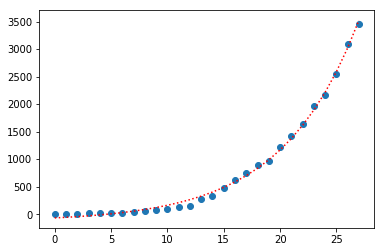

In [29]:
plt.scatter(x, y, label='data')
plt.plot(x, fitfunc(x, *popt), color='red', linestyle=':', label='fit')        